In [1]:
# %pip install pandas numpy scikit-learn matplotlib seaborn joblib flask flask-cors

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict

In [3]:
# Load the data
try:
    df = pd.read_csv('mostCommonExercises.csv')
    print("Dataset loaded successfully!")
except:
    print("Please make sure 'mostCommonExercises.csv' is in the same directory")
    exit()

print("Dataset Overview:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nTarget variable distribution:")
print(df['muscle_size_increase_cm2'].describe())

Dataset loaded successfully!
Dataset Overview:
         exercise_name target_muscle_group      type  age gender  sets  reps  \
0  Barbell Bench Press               Chest  Compound   32      M     4    10   
1  Barbell Bench Press               Chest  Compound   28      F     3    12   
2  Barbell Bench Press               Chest  Compound   39      M     5     8   
3  Barbell Bench Press               Chest  Compound   35      F     4    10   
4  Barbell Bench Press               Chest  Compound   26      M     3    12   

   weight  frequency  protein  calories  sleep    experience  \
0      80          3      150      2800    7.5  Intermediate   
1      45          2      130      2600    7.2      Beginner   
2      90          4      170      3100    8.0      Advanced   
3      50          3      135      2700    7.4  Intermediate   
4      85          2      145      2750    7.6  Intermediate   

   muscle_size_increase_cm2  genetic_advantage  actual_fat_loss  \
0                   

In [4]:
df.count()

exercise_name               389
target_muscle_group         389
type                        389
age                         389
gender                      389
sets                        389
reps                        389
weight                      389
frequency                   389
protein                     389
calories                    389
sleep                       389
experience                  389
muscle_size_increase_cm2    389
genetic_advantage           389
actual_fat_loss             389
daily_deficit               389
current_weight              389
height                      389
dtype: int64

In [5]:
# Define baseline muscle growth equation parameters with current size and diminishing returns
def get_baseline_params(age, gender, experience, current_size_cm, workout_time_years):
    if gender == 'M':
        base_limit = 45
        age_factor = max(0.7, 1 - (age - 25) * 0.01)
    else:
        base_limit = 30
        age_factor = max(0.7, 1 - (age - 25) * 0.008)
    
    M_max = base_limit * age_factor
    remaining_potential = max(0, M_max - (current_size_cm * 0.2))
    
    k_base = {'Beginner': 0.20, 'Intermediate': 0.10, 'Advanced': 0.05}
    k = k_base.get(experience, 0.10) * (1 / (1 + workout_time_years * 0.1))
    
    return remaining_potential, k

def calculate_baseline_growth(row, time_months, current_size_cm, workout_time_years):
    M_max, k = get_baseline_params(row['age'], row['gender'], row['experience'], current_size_cm, workout_time_years)
    M0 = current_size_cm * 0.2
    baseline_growth = (M_max - M0) * (1 - np.exp(-k * time_months))
    baseline_cm2 = baseline_growth * 5
    return max(baseline_cm2, 0.1)  # Ensure minimum baseline to avoid division by zero

In [6]:
# Calculate baseline growth
df['baseline_growth'] = df.apply(
	lambda row: calculate_baseline_growth(
		row, 
		time_months=3, 
		current_size_cm=0, 
		workout_time_years=0
	), 
	axis=1
)

# Calculate adjustment factor with safety measures
df['adjustment_factor'] = df['muscle_size_increase_cm2'] / df['baseline_growth']

# Cap extreme adjustment factors to prevent model instability
df['adjustment_factor'] = np.clip(df['adjustment_factor'], 0.01, 10.0)

print("\nBaseline vs Actual Growth:")
print(f"Mean baseline growth: {df['baseline_growth'].mean():.2f} cm2")
print(f"Mean actual growth: {df['muscle_size_increase_cm2'].mean():.2f} cm2")
print(f"Mean adjustment factor: {df['adjustment_factor'].mean():.2f}")


Baseline vs Actual Growth:
Mean baseline growth: 47.45 cm2
Mean actual growth: 1.88 cm2
Mean adjustment factor: 0.05


In [7]:
# Feature engineering
le_gender = LabelEncoder()
le_exercise = LabelEncoder()
le_muscle_group = LabelEncoder()
le_category = LabelEncoder()
le_experience = LabelEncoder()

df['gender_encoded'] = le_gender.fit_transform(df['gender'])
df['exercise_name_encoded'] = le_exercise.fit_transform(df['exercise_name'])
df['muscle_group_encoded'] = le_muscle_group.fit_transform(df['target_muscle_group'])
df['category_encoded'] = le_category.fit_transform(df['type'])
df['experience_encoded'] = le_experience.fit_transform(df['experience'])

# Create additional features
df['protein_per_kg'] = df['protein'] / np.maximum(df['weight'] * 0.45, 1)  # Prevent division by zero
df['volume'] = df['sets'] * df['reps']
df['intensity'] = df['weight'] / np.maximum(df['reps'], 1)  # Prevent division by zero
df['calories_per_kg'] = df['calories'] / np.maximum(df['weight'] * 0.45, 1)  # Prevent division by zero

In [8]:
# Select features for ML model
features = [
    'age', 'gender_encoded', 'exercise_name_encoded', 'sets', 'reps', 'weight',
    'frequency', 'protein', 'calories', 'sleep', 'experience_encoded',
    'muscle_group_encoded', 'category_encoded', 'protein_per_kg', 'volume',
    'intensity', 'calories_per_kg', 'genetic_advantage'
]

X = df[features]
y = df['adjustment_factor']

# Check for any remaining inf or NaN values
print(f"\nChecking for infinite values in features: {np.isinf(X).sum().sum()}")
print(f"Checking for NaN values in features: {X.isnull().sum().sum()}")

# Replace any remaining inf/NaN values
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())


Checking for infinite values in features: 0
Checking for NaN values in features: 0


In [9]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Performance:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")


Model Performance:
Mean Squared Error: 0.0000
R² Score: 0.9817


In [10]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


Top 10 Most Important Features:
               feature  importance
10  experience_encoded    0.854400
12    category_encoded    0.052066
17   genetic_advantage    0.036805
9                sleep    0.010154
0                  age    0.006743
5               weight    0.006419
7              protein    0.005613
8             calories    0.004602
16     calories_per_kg    0.004133
15           intensity    0.003987


In [11]:
# Function to safely encode new data
def safe_transform(encoder, value, default_value=0):
    """Safely transform a value using a label encoder, returning default if not found"""
    try:
        if value in encoder.classes_:
            return encoder.transform([value])[0]
        else:
            print(f"Warning: '{value}' not found in training data, using default")
            return default_value
    except:
        return default_value

# Enhanced prediction function for multiple workouts
def predict_multi_exercise_muscle_growth(age: int, gender: str, exercises: List[Dict], frequency: int, 
                                        protein: float, calories: int, sleep: float, experience: str, 
                                        current_size_cm: float = 0, workout_time_years: float = 0, time_months = 0) -> str:
    try:
        # Define difficulty weights based on exercise category
        difficulty_weights = {
            'Compound': 1.0,
            'Isolation': 0.8
        }

        # Validate inputs
        if not (18 <= age <= 100):
            raise ValueError("Age must be between 18 and 100.")
        if gender not in le_gender.classes_:
            raise ValueError(f"Gender must be one of {list(le_gender.classes_)}.")
        if experience not in le_experience.classes_:
            raise ValueError(f"Experience level must be one of {list(le_experience.classes_)}.")
        if not (1 <= frequency <= 7):
            raise ValueError("Frequency must be between 1 and 7 days per week.")
        if not (0 < protein <= 300):
            raise ValueError("Protein intake must be between 0 and 300 grams.")
        if not (0 < calories <= 5000):
            raise ValueError("Calories must be between 0 and 5000 kcal.")
        if not (0 < sleep <= 24):
            raise ValueError("Sleep must be between 0 and 24 hours.")

        # Group exercises by target muscle group
        muscle_groups = {}
        for ex in exercises:
            if not isinstance(ex, dict):
                raise ValueError("Each exercise must be a dictionary with exercise_name, sets, reps, weight, target_muscle_group, and exercise_category.")
            if ex['exercise_name'] not in le_exercise.classes_:
                raise ValueError(f"Exercise name must be one of {list(le_exercise.classes_)}.")
            if ex['target_muscle_group'] not in le_muscle_group.classes_:
                raise ValueError(f"Target muscle group must be one of {list(le_muscle_group.classes_)}.")
            if ex['exercise_category'] not in le_category.classes_:
                raise ValueError(f"Exercise category must be one of {list(le_category.classes_)}.")
            if not (1 <= ex['sets'] <= 10):
                raise ValueError("Sets must be between 1 and 10.")
            if not (1 <= ex['reps'] <= 20):
                raise ValueError("Reps must be between 1 and 20.")
            if not (0 < ex['weight'] <= 300):
                raise ValueError("Weight must be between 0 and 300 kg.")
            
            muscle_group = ex['target_muscle_group']
            if muscle_group not in muscle_groups:
                muscle_groups[muscle_group] = []
            muscle_groups[muscle_group].append(ex)

        # Predict growth for each muscle group
        results = []
        for muscle_group, ex_list in muscle_groups.items():
            total_volume = 0
            primary_exercise = None
            max_volume = 0
            for ex in ex_list:
                volume = ex['sets'] * ex['reps'] * ex['weight'] * difficulty_weights[ex['exercise_category']]
                total_volume += volume
                if volume > max_volume:
                    max_volume = volume
                    primary_exercise = ex

            # Calculate baseline growth
            baseline = calculate_baseline_growth(
                pd.Series({
                    'age': age,
                    'gender': gender,
                    'experience': experience
                }),
                time_months=time_months,
                current_size_cm=current_size_cm, 
                workout_time_years=workout_time_years
            )

            # Convert total volume to equivalent sets, reps, weight
            equiv_sets = min(10, primary_exercise['sets'])
            equiv_reps = min(20, primary_exercise['reps'])
            equiv_weight = min(300, total_volume / (equiv_sets * equiv_reps))

            # Encode inputs
            gender_encoded = safe_transform(le_gender, gender)
            exercise_encoded = safe_transform(le_exercise, primary_exercise['exercise_name'])
            experience_encoded = safe_transform(le_experience, experience)
            muscle_group_encoded = safe_transform(le_muscle_group, muscle_group)
            category_encoded = safe_transform(le_category, primary_exercise['exercise_category'])

            # Create additional features
            protein_per_kg = protein / np.maximum(equiv_weight * 0.45, 1)
            volume = equiv_sets * equiv_reps
            intensity = equiv_weight / np.maximum(equiv_reps, 1)
            calories_per_kg = calories / np.maximum(equiv_weight * 0.45, 1)

            # Create input array
            input_data = np.array([[age, gender_encoded, exercise_encoded, equiv_sets, equiv_reps, equiv_weight, 
                                   frequency, protein, calories, sleep, experience_encoded, 
                                   muscle_group_encoded, category_encoded, protein_per_kg, volume, 
                                   intensity, calories_per_kg, 3]])  # Default genetic_advantage

            # Predict adjustment factor
            adjustment = rf_model.predict(input_data)[0]
            adjustment = np.clip(adjustment, 0.01, 10.0)
            num_exercises = len(ex_list)
            adjustment_factor = 1 + 0.1 * (num_exercises - 1)  # 10% boost per additional exercise
            adjustment *= min(1.3, adjustment_factor)  # Cap at 30% boost

            # Final prediction
            prediction = baseline * adjustment
            results.append(f"{muscle_group} growth: {round(prediction, 2)} cm²")

        return "\n".join(results) if results else "No valid exercises provided."

    except Exception as e:
        return f"Error: {str(e)}"

In [12]:
# Example usage with a complete workout
exercises = [
    {
        'exercise_name': 'Dumbbell Flyes',
        'sets': 3,
        'reps': 12,
        'weight': 20,
        'target_muscle_group': 'Chest',
        'exercise_category': 'Isolation'
    },
]

# Test the prediction function
result = predict_multi_exercise_muscle_growth(
    age=2,
    gender='M',
    exercises=exercises,
    frequency=3,
    protein=150,
    calories=2800,
    sleep=7.5,
    experience='Intermediate',
    current_size_cm=30,
    workout_time_years=2,
    time_months=3  # Adding the time_months parameter
)

print("Prediction Results:")
print(result)

Prediction Results:
Error: Age must be between 18 and 100.


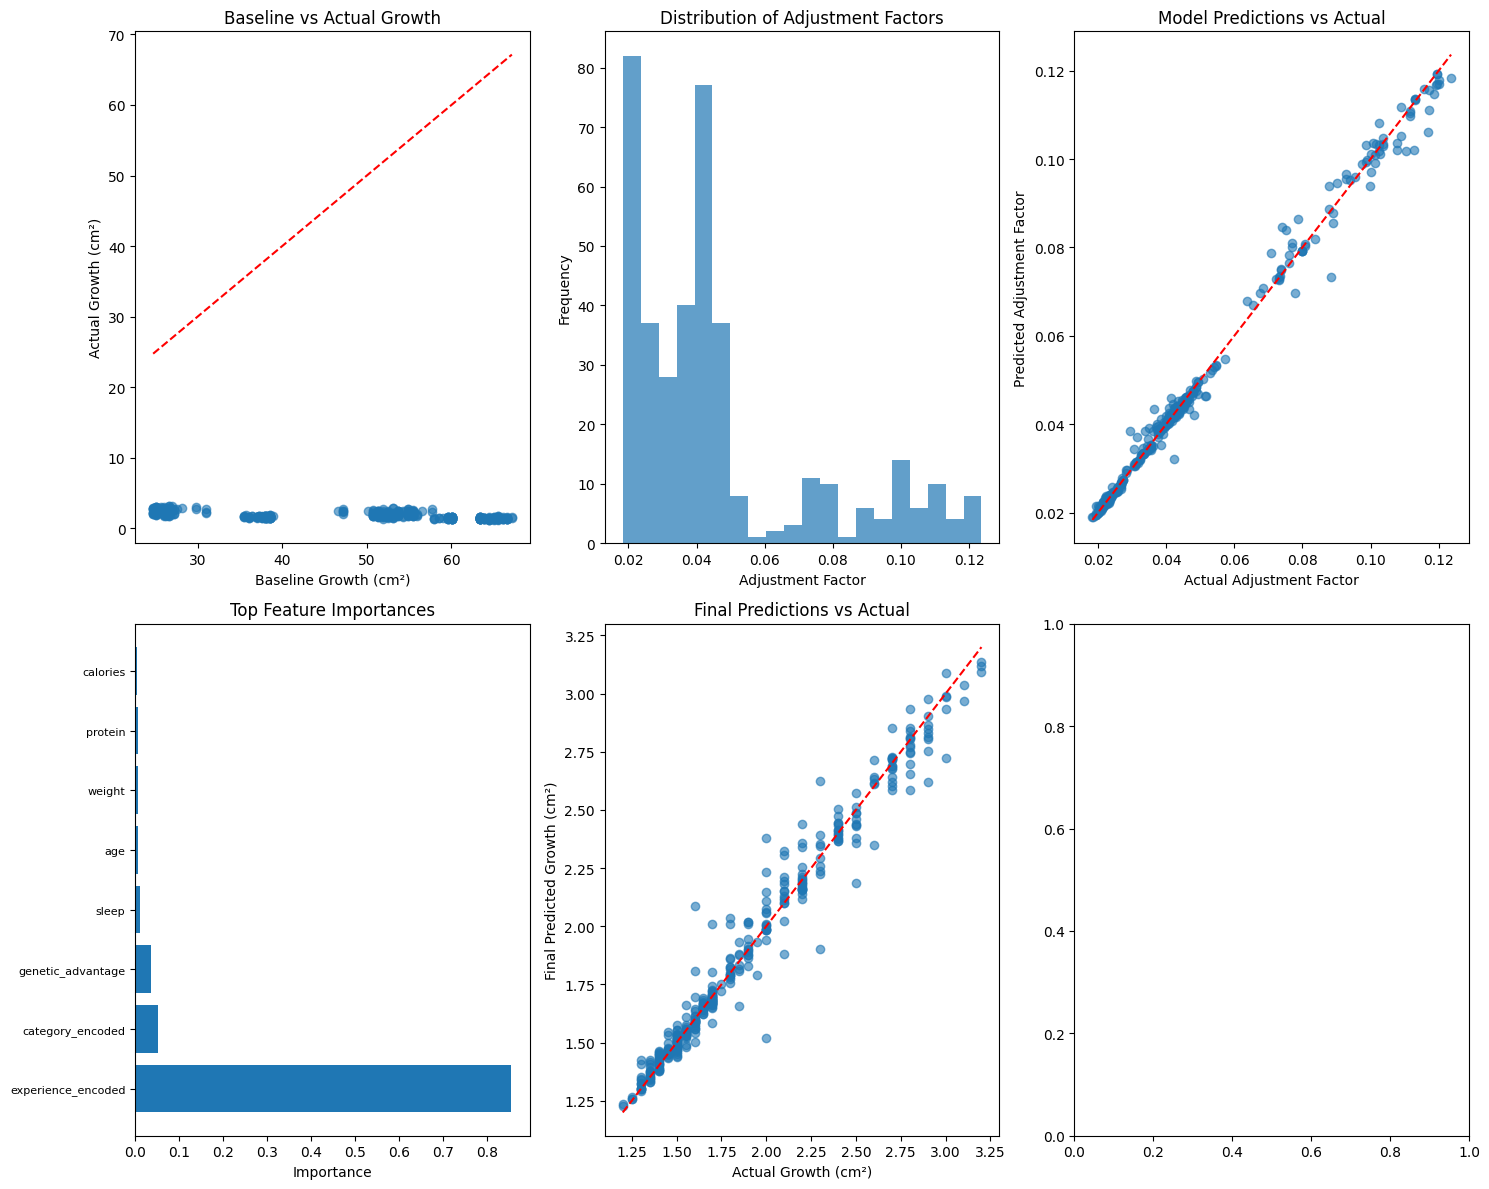

In [13]:
# Visualizations
plt.figure(figsize=(15, 12))

# Plot 1: Baseline vs Actual
plt.subplot(2, 3, 1)
plt.scatter(df['baseline_growth'], df['muscle_size_increase_cm2'], alpha=0.6)
plt.plot([df['baseline_growth'].min(), df['baseline_growth'].max()],
         [df['baseline_growth'].min(), df['baseline_growth'].max()], 'r--')
plt.xlabel('Baseline Growth (cm²)')
plt.ylabel('Actual Growth (cm²)')
plt.title('Baseline vs Actual Growth')

# Plot 2: Adjustment factors
plt.subplot(2, 3, 2)
plt.hist(df['adjustment_factor'], bins=20, alpha=0.7)
plt.xlabel('Adjustment Factor')
plt.ylabel('Frequency')
plt.title('Distribution of Adjustment Factors')

# Plot 3: Predicted vs Actual
plt.subplot(2, 3, 3)
y_pred_full = rf_model.predict(X)
plt.scatter(y, y_pred_full, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual Adjustment Factor')
plt.ylabel('Predicted Adjustment Factor')
plt.title('Model Predictions vs Actual')

# Plot 4: Feature importance
plt.subplot(2, 3, 4)
top_features = feature_importance.head(8)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'], fontsize=8)
plt.xlabel('Importance')
plt.title('Top Feature Importances')

# Plot 5: Final predictions
plt.subplot(2, 3, 5)
final_predictions = df['baseline_growth'] * y_pred_full
plt.scatter(df['muscle_size_increase_cm2'], final_predictions, alpha=0.6)
plt.plot([df['muscle_size_increase_cm2'].min(), df['muscle_size_increase_cm2'].max()],
         [df['muscle_size_increase_cm2'].min(), df['muscle_size_increase_cm2'].max()], 'r--')
plt.xlabel('Actual Growth (cm²)')
plt.ylabel('Final Predicted Growth (cm²)')
plt.title('Final Predictions vs Actual')

# Plot 6: Workout prediction results
plt.subplot(2, 3, 6)
muscle_groups = []
growth_values = []
for line in result.split("\n"):
    if "Error" not in line and line:
        muscle, value = line.split(" growth: ")
        muscle_groups.append(muscle)
        growth_values.append(float(value.split(" cm²")[0]))

if muscle_groups:
    plt.bar(muscle_groups, growth_values, color=['#1f77b4', '#ff7f0e'])
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.ylabel('Predicted Growth (cm²)')
    plt.title('Predicted Muscle Growth per Muscle Group')
    plt.ylim(0, max(growth_values) + 2)
    for i, v in enumerate(growth_values):
        plt.text(i, v + 0.2, f"{v:.2f}", ha='center')

plt.tight_layout()
plt.show()

In [14]:
import joblib
filename = "bulkPredictor.pkl"
joblib.dump(rf_model, filename)

joblib.dump(le_gender, 'le_gender.pkl')
joblib.dump(le_exercise, 'le_exercise.pkl')
joblib.dump(le_experience, 'le_experience.pkl')
joblib.dump(le_muscle_group, 'le_muscle_group.pkl')
joblib.dump(le_category, 'le_category.pkl')

['le_category.pkl']

In [15]:
# Model summary
print("\n" + "="*60)
print("MODEL SUMMARY")
print("="*60)
print(f"✓ Model trained on {len(df)} exercise records")
print(f"✓ R² Score: {r2:.3f} (explains {r2*100:.1f}% of variance)")
print(f"✓ Supports {len(le_exercise.classes_)} different exercises")
print(f"✓ Covers {len(le_muscle_group.classes_)} muscle groups")
print(f"✓ Ready for workout predictions!")

print("\nAvailable exercises in the model:")
for i, exercise in enumerate(sorted(le_exercise.classes_)):
    print(f"{i+1:2d}. {exercise}")


MODEL SUMMARY
✓ Model trained on 389 exercise records
✓ R² Score: 0.982 (explains 98.2% of variance)
✓ Supports 39 different exercises
✓ Covers 4 muscle groups
✓ Ready for workout predictions!

Available exercises in the model:
 1. 21s
 2. Barbell Bench Press
 3. Barbell Curls
 4. Barbell Rows
 5. Cable Crossover
 6. Cable Curls
 7. Chest Dips
 8. Chin-ups
 9. Close Grip Lat Pulldowns
10. Concentration Curls
11. Deadlifts
12. Decline Barbell Bench Press
13. Decline Dumbbell Press
14. Dumbbell Bench Press
15. Dumbbell Curls
16. Dumbbell Flyes
17. Dumbbell Rows
18. Face Pulls
19. Good Mornings
20. Hammer Curls
21. Hyperextensions
22. Incline Barbell Bench Press
23. Incline Dumbbell Flyes
24. Incline Dumbbell Press
25. Lat Pulldowns
26. Machine Chest Press
27. Pec Deck Machine
28. Preacher Curls
29. Pull-ups
30. Push-ups
31. Rack Pulls
32. Reverse Flyes
33. Romanian Deadlifts
34. Seated Cable Rows
35. Shrugs
36. Sumo Deadlifts
37. T-Bar Rows
38. Upright Rows
39. Wide Grip Lat Pulldowns


In [ ]:
from flask import Flask, request, jsonify
from flask_cors import CORS

app = Flask(__name__)
CORS(app)  # Enable CORS for all routes

@app.route('/bulk', methods=['POST'])
def predict():
    try:
        data = request.get_json()
        age = data.get('age')
        gender = data.get('gender')
        exercises = data.get('exercises')
        frequency = data.get('frequency')
        protein = data.get('protein')
        calories = data.get('calories')
        sleep = data.get('sleep')
        experience = data.get('experience')
        current_size_cm = data.get('current_size_cm', 0)
        workout_time_years = data.get('workout_time_years', 0)

        # Define fixed intervals
        intervals = [3, 6, 9, 12]
        result = {}

        for interval in intervals:
            # Call the existing prediction function with the current interval
            prediction_str = predict_multi_exercise_muscle_growth(
                age=age,
                gender=gender,
                exercises=exercises,
                frequency=frequency,
                protein=protein,
                calories=calories,
                sleep=sleep,
                experience=experience,
                current_size_cm=current_size_cm,
                workout_time_years=workout_time_years,
                time_months=interval
            )
            
            # Parse the string into a dict for this interval
            interval_predictions = {}
            for line in prediction_str.split("\n"):
                if line and "growth:" in line and "Error" not in line:
                    parts = line.split(" growth: ")
                    if len(parts) == 2:
                        muscle = parts[0].strip()
                        try:
                            # Extract the numeric value (remove "cm²" or "cmÂ²")
                            value_str = parts[1].strip().replace("cm²", "").replace("cmÂ²", "").strip()
                            value = float(value_str)
                            # Format the key as "{muscle} growth"
                            interval_predictions[f"{muscle} growth"] = f"{value} cm2"
                        except (ValueError, IndexError):
                            pass  # Skip invalid lines
            
            # Only add to result if we have predictions for this interval
            if interval_predictions:
                result[str(interval)] = interval_predictions

        return jsonify({'result': result})
        
    except Exception as e:
        return jsonify({'error': str(e)}), 400

@app.route('/health', methods=['GET'])
def health_check():
    return jsonify({'status': 'healthy', 'message': 'Bulk predictor API is running'})

if __name__ == '__main__':
    app.run(host='localhost', port=3001)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://localhost:3001
Press CTRL+C to quit


In [ ]:
from sklearn.metrics import accuracy_score

# For regression, accuracy is not standard, but we can compute the percentage of predictions within a tolerance
tolerance = 0.1  # 10% tolerance
accuracy = np.mean(np.abs(y_pred - y_test) <= tolerance * np.abs(y_test))

print("Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Accuracy (within ±10% of actual): {accuracy*100:.2f}%")